Ad : Nahit Furkan

Soyad : Öznamlı

Okul No : 2212721020

GitHub Repo Bağlantısı: https://github.com/FurkanOznamli/CNN_siniflandirma

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/dataset_split"

train_dir = base_dir + "/train"
val_dir   = base_dir + "/val"
test_dir  = base_dir + "/test"

IMG_HEIGHT = 128
IMG_WIDTH  = 128
BATCH_SIZE = 32
EPOCHS = 15

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Sınıf indeksleri:", train_generator.class_indices)


Mounted at /content/drive
Found 176 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Sınıf indeksleri: {'kutu': 0, 'sise': 1}


Adım 1.2: Veri Setinin Yüklenmesi ve Data Generator Tanımları (Model 1 – ResNet50)

Bu adımda, ResNet50 tabanlı transfer learning modeli için
önceden oluşturulmuş **train / validation / test** ayrımına sahip veri seti
Keras `ImageDataGenerator` sınıfı kullanılarak yüklenmiştir.

Veri Seti Yapısı
Kullanılan veri seti aşağıdaki klasör yapısına sahiptir:

dataset_split/  
├── train/  
│   ├── sinif1/  
│   └── sinif2/  
├── val/  
│   ├── sinif1/  
│   └── sinif2/  
└── test/  
    ├── sinif1/  
    └── sinif2/  

Bu yapı sayesinde eğitim, doğrulama ve test işlemleri birbirinden
tamamen ayrılmış ve model performansı **adil bir şekilde**
değerlendirilmiştir.

---

Görüntü Ön İşleme
Tüm görüntüler:
- **128x128 piksel** boyutuna yeniden ölçeklendirilmiş,
- Piksel değerleri **[0,1] aralığına** normalize edilmiştir (`rescale=1./255`).

Bu ön işleme adımı, ResNet50 modelinin daha stabil ve hızlı
öğrenmesine katkı sağlamaktadır.

---

Data Generator Tanımları

- **Train Generator:**  
  Eğitim verilerini yüklemek için kullanılmıştır. Bu aşamada veri artırımı
  uygulanmamış, yalnızca normalizasyon işlemi gerçekleştirilmiştir.

- **Validation Generator:**  
  Eğitim sırasında modelin doğrulama performansını izlemek amacıyla
  kullanılmıştır.

- **Test Generator:**  
  Modelin genelleme performansını ölçmek için, eğitim ve doğrulama
  aşamalarında kullanılmayan test verileri üzerinde değerlendirme yapılmıştır.
  `shuffle=False` parametresi, test çıktılarının sırasının korunması için
  tercih edilmiştir.

---

Sınıf Etiketleri

Problemin iki sınıflı olması nedeniyle `class_mode='binary'` kullanılmıştır.
Oluşturulan sınıf–etiket eşleşmeleri `class_indices` ile kontrol edilmiştir.

Bu veri yükleme yapısı, ResNet50 tabanlı Model 1’in,
Model 2 ve Model 3 ile **aynı veri bölünmesi** üzerinden
karşılaştırılabilmesini sağlamaktadır.


In [2]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(128,128,3)
)

base_model.trainable = False  # Transfer learning

model1 = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation="relu"),
    Dense(1, activation="sigmoid")
])

model1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model1.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,365,953 (153.98 MB)

 Trainable params: 16,778,241 (64.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Adım 1.3: ResNet50 Tabanlı Transfer Learning Modelinin Oluşturulması

Bu aşamada, transfer learning yaklaşımı kullanılarak
ImageNet veri seti üzerinde önceden eğitilmiş olan **ResNet50**
mimarisi temel model (base model) olarak kullanılmıştır.

ResNet50 Taban Modeli
- `weights="imagenet"` parametresi ile ResNet50 modeli,
  ImageNet veri seti üzerinde öğrenilmiş ağırlıklarla yüklenmiştir.
- `include_top=False` seçeneği sayesinde ResNet50’nın orijinal
  sınıflandırma katmanları çıkarılmış ve model yalnızca
  **özellik çıkarıcı (feature extractor)** olarak kullanılmıştır.
- `input_shape=(128,128,3)` parametresi ile giriş görüntü boyutu
  proje gereksinimlerine uygun şekilde ayarlanmıştır.

Temel modelin ağırlıkları dondurulmuştur (`trainable = False`).
Bu sayede eğitim sırasında yalnızca üst katmanların
öğrenmesi sağlanmış ve küçük veri setlerinde
**aşırı öğrenme (overfitting)** riski azaltılmıştır.

---

Özel Sınıflandırma Katmanları

ResNet50 taban modelinin üzerine aşağıdaki katmanlar eklenmiştir:

- **Flatten:**  
  Çıkarılan özellik haritalarını tek boyutlu bir vektöre dönüştürür.
- **Dense (512, ReLU):**  
  Yüksek boyutlu özelliklerin daha anlamlı bir temsilini öğrenmek için
  tam bağlantılı katman eklenmiştir.
- **Dense (1, Sigmoid):**  
  İki sınıflı sınıflandırma problemi için çıktı katmanı olarak
  sigmoid aktivasyon fonksiyonu kullanılmıştır.

Bu yapı, ResNet50’nın güçlü özellik çıkarma kabiliyeti ile
basit bir sınıflandırma başlığını birleştirmektedir.

---

Model Derleme (Compile)

Model aşağıdaki ayarlar ile derlenmiştir:

- **Optimizer:** Adam (`learning_rate = 0.0001`)  
  Düşük öğrenme oranı, transfer learning senaryolarında
  daha stabil ve kontrollü bir eğitim süreci sağlar.
- **Loss Function:** Binary Crossentropy  
  İki sınıflı sınıflandırma problemleri için uygun bir kayıp fonksiyonudur.
- **Metric:** Accuracy  
  Model performansı doğruluk metriği ile izlenmiştir.

Bu yapı ile oluşturulan ResNet50 tabanlı model,
state-of-the-art bir mimari kullanılarak
küçük ölçekli bir veri seti üzerinde
transfer learning yaklaşımının etkisini incelemek amacıyla
eğitilmiştir.


In [3]:
history1 = model1.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)
# modeli eğitmek için kullanılan kod bloğu

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 79s 11s/step - accuracy: 0.4664 - loss: 0.7936 - val_accuracy: 0.5946 - val_loss: 0.7690
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5784 - loss: 0.7209 - val_accuracy: 0.4324 - val_loss: 0.7008
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6242 - loss: 0.6623 - val_accuracy: 0.5946 - val_loss: 0.6860
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5715 - loss: 0.6782 - val_accuracy: 0.5946 - val_loss: 0.6319
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7678 - loss: 0.6097 - val_accuracy: 0.5946 - val_loss: 0.6097
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5987 - loss: 0.6220 - val_accuracy: 0.7568 - val_loss: 0.5750
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7450 - loss: 0.5597 - val_accuracy: 0.8108 - val_loss: 0.5681
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8598 - loss: 0.5517 - val_accuracy: 0.7568 - val_loss: 0.5500
Epoch 9

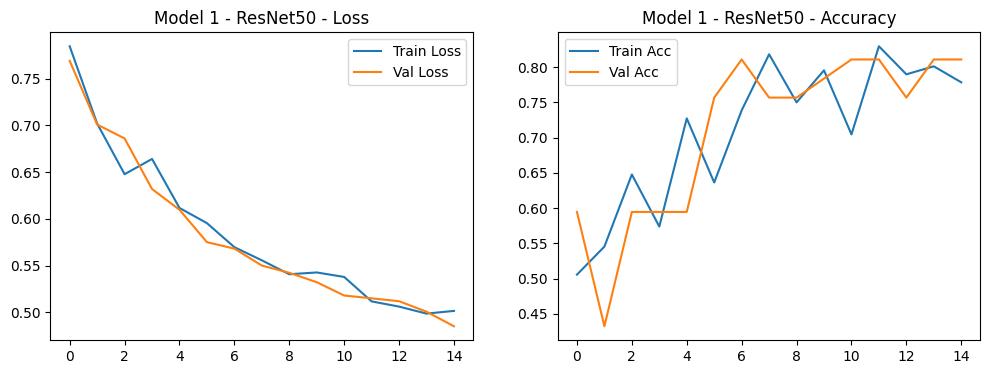

In [4]:
def plot_history(history, model_name):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(model_name + " - Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title(model_name + " - Accuracy")
    plt.legend()

    plt.show()

plot_history(history1, "Model 1 - ResNet50")

# grafikleri çizmek için gerekli kodlar


Model 1 (ResNet50) – Eğitim Süreci Grafiklerinin Yorumu



Kayıp (Loss) Grafiği Yorumu

Eğitim kaybı (Train Loss), epoch sayısı arttıkça kademeli olarak azalmıştır.
Bu durum, modelin eğitim sürecinde veri setindeki örüntüleri öğrenmeye
başladığını göstermektedir.

Doğrulama kaybı (Validation Loss) da benzer bir düşüş eğilimi sergilemiş
ve eğitim kaybı ile paralel bir seyir izlemiştir.
Kayıp eğrileri arasında belirgin bir ayrışma olmaması,
modelin eğitim sürecinin stabil ilerlediğini göstermektedir.

---

Doğruluk (Accuracy) Grafiği Yorumu

Eğitim doğruluğu (Train Accuracy), epoch’lar boyunca artış göstermiş ancak
belirli epoch’larda dalgalanmalar gözlemlenmiştir.
Bu durum, ResNet50 gibi derin bir mimarinin küçük veri setleri üzerinde
öğrenme sürecinde kararsızlık yaşayabildiğini göstermektedir.

Doğrulama doğruluğu (Validation Accuracy) da benzer şekilde dalgalı bir
yapı sergilemiş ve eğitim doğruluğuna yakın değerlerde seyretmiştir.
Bu dalgalanmalar, modelin doğrulama verisi üzerinde tutarlı bir şekilde
genelleme yapmakta zorlandığını işaret etmektedir.

---

Genel Değerlendirme

Kayıp değerlerinin düzenli olarak azalmasına rağmen,
doğruluk eğrilerindeki dalgalı yapı,
ResNet50 modelinin bu veri seti için
daha karmaşık bir mimari olabileceğini göstermektedir.

Bu grafikler, ResNet50’nın güçlü bir mimari olmasına rağmen,
küçük ölçekli ve iki sınıflı veri setlerinde
daha basit transfer learning modellerine kıyasla
daha az stabil sonuçlar üretebileceğini ortaya koymaktadır.


In [5]:
loss1, acc1 = model1.evaluate(test_generator, verbose=1)

print("="*50)
print(f"Model 1 (ResNet50) TEST Accuracy: %{acc1*100:.2f}")
print("="*50)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.8250 - loss: 0.4738
Model 1 (ResNet50) TEST Accuracy: %80.00


Model 1 (ResNet50) – Test Seti Değerlendirmesi

Bu aşamada, ResNet50 tabanlı transfer learning modeli,
eğitim ve doğrulama süreçlerinde kullanılmayan
**test veri seti** üzerinde değerlendirilmiştir.

Test değerlendirmesi sonucunda:
- Modelin test doğruluğu **%80** olarak elde edilmiştir.
- Test kayıp (loss) değeri, modelin test verisi üzerinde
  belirli bir hata payına sahip olduğunu göstermektedir.

Bu sonuç, ResNet50 mimarisinin güçlü bir özellik çıkarıcı olmasına rağmen,
küçük ve iki sınıflı veri setlerinde
daha karmaşık yapısı nedeniyle
genelleme performansının sınırlı kalabileceğini göstermektedir.
